In [9]:
# Environment Setup
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
sp.init_printing()

# Move Kinematics

Every move has a target "entry" and "exit" velocity that we must keep when entering or exiting the move. Within this move, the velocity can be anything. It makes sense to maximize the time spent cruising at a target upper bound on velocity, which we call the "cruise velocity." Spending the most time here means our overall series of paths that we're trying to execute are executing as quickly as possible while respecting the physical acceleration limits we apply to the machine.

## General Case
To follow a trapezoidal velocity profile, we actually have 3 move regions.

When accelerating, we follow
$$
x_a(t) = x_0 + v_0t + \frac{1}{2}at^2
$$
When cruising, we follow:
$$
x_c(t) = x_0 + v_0t
$$
When decelerating, our starting position is now wherever we finished off after cruising, our starting velocity is our cruise velocity, and our starting $a$ flips from positive to negative from our accelerating equation. If $a$ is a constant, we get:
$$
x_d(t) = x_{cf} + v_ct - \frac{1}{2}at^2
$$



## "Short Move" Case
Some moves are so short, the machine carriage never has enough time to get to the cruise velocity. In that case, we just do our best. Since we'll be planning two regions, we need to know when (or equivalently at what position) they intersect.

The cell below solves for the max velocity when we never have a cruise region.

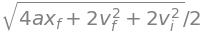

In [10]:
t_i, t_m, t_f, v_i, v_m, v_f, v_c, x_f, t, a = sp.symbols('t_i, t_m, t_f, v_i, v_m, v_f, v_c, x_f, t, a')

x_f_fn = v_i*t_m + sp.Rational(1,2)*a*t_m**2 + v_m*(t_f - t_m) - sp.Rational(1,2)*a*(t_f - t_m)**2 - x_f
v_max_fn = v_i + a*t_m - v_m
v_f_fn = v_m - a*(t_f-t_m) - v_f

# We get two solutions. For positive a, v_i, and v_f (which will always be true), we want the first solution
solns = sp.solve([x_f_fn, v_max_fn, v_f_fn], t_f, v_m, t_m)

t_final, v_max, t_max = solns[0]
givens = {v_f: 1,
          v_i: 1,
          x_f: 1,
          a: 10}
#display(t_final.subs(givens).evalf())
#display(v_max.subs(givens).evalf())
#display(t_max.subs(givens).evalf())

display(v_max)

## X inverses
The above kinematics equations give us x as a function of time. But since stepper motors can only move in discrete position steps, we actually want time as a function of the next possible position. That means we need the inverse function for all three regions.

## Calculating Time Analytically
Each region gets its own equation.

The cruise region is easy since acceleration is zero and our equation is a line.

In [11]:
x, x_i, v_cruise, t = sp.symbols('x, x_i, v_c, t')
sp.solve(x_i + v_cruise*t - x, t)

The regions where we're accelerating/decelerating have two solutions, but only one is valid (where $t \ge 0$).

For the accelerating region, we get:

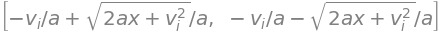

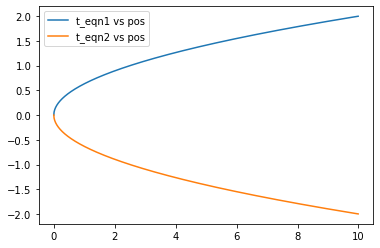

In [13]:
x, x_i, v_i = sp.symbols('x, x_i, v_i')
a = sp.symbols('a', positive=True)
v_cruise = sp.symbols('v_c', positive=True)
t = sp.symbols('t', positive=True, real=True)

givens = {x_i: 0}
t_eqns = list(sp.solveset((x_i + v_i*t + sp.Rational(1,2)*a*t**2 - x).subs(givens), t))
display(t_eqns)

givens = {a: 5,
          v_i: 0,
          v_cruise: 10,
          x_i: 0}
#t_eqns = list()
t_eqn1 = sp.lambdify(x, t_eqns[0].subs(givens))
t_eqn2 = sp.lambdify(x, t_eqns[1].subs(givens))

pos_series = np.arange(0, 10, 0.01)
t_eqn1_series = [t_eqn1(x) for x in pos_series]
t_eqn2_series = [t_eqn2(x) for x in pos_series]

plt.plot(pos_series, t_eqn1_series, label = "t_eqn1 vs pos")
plt.plot(pos_series, t_eqn2_series, label="t_eqn2 vs pos")
plt.legend()
plt.show()

Here, we can see that we want to take the first eqn, where $t$ is strictly positive.


For the decelerating region, we get:

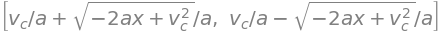

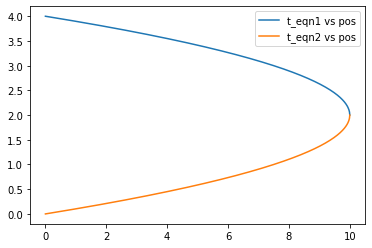

In [15]:
givens = {x_i: 0}
t_eqns = list(sp.solveset((x_i + v_cruise*t - sp.Rational(1,2)*a*t**2 - x).subs(givens), t))
display(t_eqns)

givens = {a: 5, # minus sign is in the eqn.
          v_i: 0,
          v_cruise: 10,
          x_i: 0}
t_eqn1 = sp.lambdify(x, t_eqns[0].subs(givens))
t_eqn2 = sp.lambdify(x, t_eqns[1].subs(givens))

pos_series = np.arange(0, 10.01, 0.01)
t_eqn1_series = [t_eqn1(x) for x in pos_series]
t_eqn2_series = [t_eqn2(x) for x in pos_series]

plt.plot(pos_series, t_eqn1_series, label = "t_eqn1 vs pos")
plt.plot(pos_series, t_eqn2_series, label="t_eqn2 vs pos")
plt.legend()
plt.show()

Here we want to take the second equation, which is defined from $t=0$ to $t=2$.

We can put all of this together into a Move Class now.

In [16]:
class Move(object):
    """A line segment move.
    A single move is given entry/exit velocitys and planned with a profile to:
        1. Accelerate from entry velocity up to the cruise velocity
        2. Cruise
        3. Decelerate to the exit velocity
    
    Note: velocities will never exceed the cruise velocity.
    Note: all time calculations below are done relative to this move only. 
        i.e: this move starts at t=0
    """
    v_cruise = 10.0 # mm/sec
    accel = 5.0 # mm/(sec^2)
    
    def __init__(self, v_initial, v_final, start_pos, end_pos, constant_velocity=False):
        """init
        param constant_velocity: a flag telling us to hold velocity constant throughout the entire move.
            v_initial and v_final must also be the same.
        """
        assert all(((v_initial <= self.v_cruise), 
                    (v_final <= self.v_cruise))), \
                   "Error: desired move velocities exceed the cruise velocity!"
        self.v_initial = v_initial # entry velocity
        self.v_final = v_final # exit velocity
        self.positions = (start_pos, end_pos)
        self.constant_velocity = constant_velocity
        
        self.move_distance = np.sqrt((self.positions[0][0]  - self.positions[1][0])**2 +
                            (self.positions[0][1] - self.positions[1][1])**2)
        
        # These get defined in _compute_move_profile_times
        self.t_move_end = None
        self.t_cruise_start = None
        self.t_cruise_end = None
        self.v_max = None
        self._compute_move_profile_times()
        
        
    def _compute_move_profile_times(self):
        """Compute the times where velocity is increasing, constant, and decreasing.
        i.e: self.t_cruise_start, self.t_cruise_end, self.t_move_end
        """
        # Case 1: 1 region. Velocity constant throughout.
        if self.constant_velocity and np.allclose(self.v_initial, self.v_final):
            self.t_move_end = self.move_distances/self.v_cruise
            self.t_cruise_start = 0
            self.t_cruise_end = self.move_distance / self.v_cruise
            self.v_max = self.v_cruise
            return
        
        # line intersect v_accel(t) with v_cruise(t) and v_cruise(t) with v_decel(t).
        accel_region_distance = (self.v_cruise**2 - self.v_initial**2)/(2*self.accel)
        decel_region_distance = (self.v_cruise**2 - self.v_final**2)/(2*self.accel)
        # Case 2: 2 regions. No cruise region. accel/decel_region_distances above are invalid 
        if (accel_region_distance + decel_region_distance) >= self.move_distance:
            self.no_cruise_region = True
            # (v_max, t_max) intersection point comes from solving system of eqns from
            # (1) increasing velocity eqn, (2) decreasing velocity eqn, (3) total distance traveled eqn.
            # Once we have v_max, t_max can be computed by plugging in v_max elsewhere.
            self.v_max = np.sqrt(4 * self.accel * self.move_distance + 2*self.v_final**2 + 2*self.v_initial**2)/2
            t_max = (self.v_max - self.v_initial)/self.accel
            self.t_cruise_start = t_max # Set such that later eqns resolve nicely.
            self.t_cruise_end = t_max
            accel_region_distance = (self.v_max + self.v_initial)/2*self.t_cruise_start
            decel_region_distance = self.move_distance - accel_region_distance
            self.t_move_end = t_max - (self.v_final - self.v_max)/self.accel # minus since a is negative
            return
        
        # General: 3 distinct regions. Accelerating, Cruising, Decelerating
        cruise_distance = self.move_distance - accel_region_distance - decel_region_distance
        self.t_cruise_start = (self.v_cruise - self.v_initial)/self.accel
        print(f"t_cruise_start: {self.t_cruise_start}")
        self.t_cruise_end = self.t_cruise_start + cruise_distance/self.v_cruise
        print(f"t_cruise_end: {self.t_cruise_end}")
        decel_interval = -(self.v_final - self.v_cruise)/self.accel
        self.t_move_end = self.t_cruise_end + decel_interval
        self.v_max = self.v_cruise
        return
    

    def get_position(self, t, ignore_bounds=False):
        """Return the position in the move as a function of time"""
        if (not ignore_bounds) and (t > self.t_move_end or t < 0):
            raise IndexError(f"position at time {t} is out of bounds.")
            
        # General Case: 3 veloctiy profiles
        # 1st Region case
        if t < self.t_cruise_start:
            return self.v_initial*t + 0.5*self.accel*t**2

        # 2nd Region case. Should not evaluate if no cruise region.
        if t < self.t_cruise_end:
            return (self.v_max**2 - self.v_initial**2)/(2*self.accel) + \
                (t - self.t_cruise_start)*self.v_max

        # 3rd Region case
        position = 0
        position += (self.v_max**2 - self.v_initial**2)/(2*self.accel)
        position += self.v_max*(self.t_cruise_end - self.t_cruise_start) # 0 if no cruise region.
        delta_t = (t - self.t_cruise_end)
        position += self.v_max*delta_t - 0.5*self.accel*delta_t**2
        return position
    
    def get_velocity(self, t, ignore_bounds = False):
        """Return the velocity at time t"""
        if (not ignore_bounds) and (t > self.t_move_end or t < 0):
            raise IndexError(f"velocity at time {t} is out of bounds.")
            
        # General Case: 3 veloctiy profiles
        # 1st Region case
        if t < self.t_cruise_start:
            return self.v_initial + self.accel*t

        # 2nd Region case. Should not evaluate if no cruise region.
        if t < self.t_cruise_end:
            return self.v_max

        # 3rd Region case
        return self.v_max - self.accel*(t - self.t_cruise_end)
    
    def get_acceleration(self, t, ignore_bounds = False):
        """Return the acceleration at time t"""
        if (not ignore_bounds) and (t > self.t_move_end or t < 0):
            raise IndexError(f"acceleration at time {t} is out of bounds.")
            
        # General Case: 3 veloctiy profiles
        # 1st Region case
        if t < self.t_cruise_start:
            return self.accel

        # 2nd Region case. Should not evaluate if no cruise region.
        if t < self.t_cruise_end:
            return 0

        # 3rd Region case
        return -self.accel
    
    def get_time_at_pos(self, x):
        """compute t = x^(-1)(x) directly to retrieve the time for a given position"""
        # TODO: compute these up-front.
        cruise_region_start = self.get_position(self.t_cruise_start)
        cruise_region_end = self.get_position(self.t_cruise_end)
        
        if x < cruise_region_start:
            return 0 # TODO: compute. Choose root.
        if x < cruise_region_end:
            return 0 # TODO: compute
        # Default:
            return 0 # TODO: compute. Choose root.
            
    
    def get_time_at_pos_newton(self, x, t_i=None):
        """for a given x location and initial time guess t_i, computes inverse function to approximate the time
            at which we reach the desired position."""
        epsilon = 1e-7 # 100 nanoseconds

        # division-by-zero checks: any case where v(t) could equal zero.
        # Since we specify entry and exit velocities >= 0, check their corresponding positions.
        if np.allclose(x, 0):
            return 0

        if np.allclose(x, self.move_distance):
            print("close to end of move. Exiting.")
            return self.t_move_end

        # Make a valid non-zero guess.
        # Weight the guess closer to the beginning of the time range
        # since we usually call this function without a guess near t=0.
        if t_i == None:
            t_i = 0.1*self.move_distance/self.v_max
            print(f"seed guess: {t_i}")
            
        # We can't guess t_i = 0 or the iterative solver denominator blows up.            
        if np.allclose(t_i, 0):
            t_i = 10*epsilon
            print("avoid divide by zero snafu")
        
        # General case: successivly better Taylor Approximations via Newton's Method
        error = np.inf
        epsilon = 1e-7
        iterations = 0
        while abs(error) > epsilon:
            iterations+=1
            # t_{i+1} = t_i + (x - x(t_i))/x'(t_i)
            t_new = t_i + (x - self.get_position(t_i, ignore_bounds=True))/\
                           self.get_velocity(t_i, ignore_bounds=True)
            error = t_new - t_i
            t_i = t_new
        #print(f"total iterations: {iterations}")
        return t_i

    
    @classmethod
    def set_cruise_velocity(cls, v):
        """Set the global cruise velocity"""
        assert v > 0, "Cannot set cruise velocity to a negative value."
        cls.cruise_velocity = v
        
    @classmethod
    def set_accel(cls, a):
        """Set the nominal constant acceleration value."""
        assert a > 0, "Cannot set nominal acceleration to a negative value"
        cls.accel = a

t_cruise_start: 2.0
t_cruise_end: 5.0


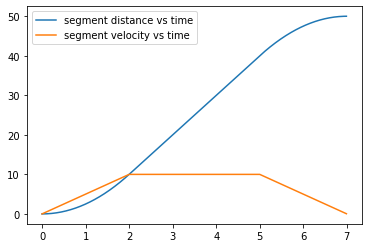

In [17]:
my_move = Move(0.0, 0.0, (0.0, 0.0), (50, 0.0))
time_series = np.arange(0, my_move.t_move_end, 0.01)
dist_series = [my_move.get_position(t) for t in time_series]
velocity_series = [my_move.get_velocity(t) for t in time_series]
plt.plot(time_series, dist_series, label = "segment distance vs time")
plt.plot(time_series, velocity_series, label = "segment velocity vs time")
plt.legend()
plt.show()

## Calculating Position with Newton's Method

Newton's method is an iterative method that let's us approximate a differentiable function with better-and-better guesses. If, for some reason, we can't compute the inverse analytically, Newton's Method is a pretty fast way of finding the inverse.

seed guess: 0.5


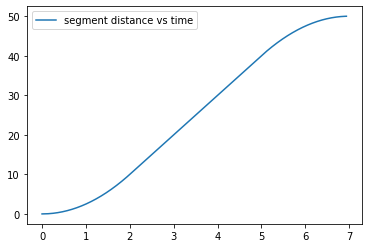

In [18]:
# Recalculate the position curve above by computing the function inverse.
dist_series = np.arange(0, 50, 0.01)
time_series = []
for index in range(len(dist_series)):
    # Use the previous time as a guess to seed the next answer.
    # Avoid cases where any guess would produce division-by-zero (v(guess) = 0)
    if np.allclose(dist_series[index], 0) or np.allclose(dist_series[index-1], 0):
        time_series.append(my_move.get_time_at_pos_newton(dist_series[index]))
        continue
    time_series.append(my_move.get_time_at_pos_newton(dist_series[index], time_series[index - 1]))

plt.plot(time_series, dist_series, label = "segment distance vs time")
plt.legend()
plt.show()

# References

### Motion Control
* [GRBL Motion Planner Source Code](https://github.com/grbl/grbl/blob/master/grbl/planner.c)
* [Klipper Kinematics](https://github.com/KevinOConnor/klipper/blob/master/docs/Kinematics.md)


### Math
* [1D Kinematics Formulas for constant Acceleration](https://www.khanacademy.org/science/physics/one-dimensional-motion/kinematic-formulas/a/what-are-the-kinematic-formulas)
* [Root Solving with Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method#Description)
* [Exponential Fitting with Python](https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly) (unused)